## Introduction - Task 2 definition

Choose a time-series prediction algorithm and apply it on stock ‘US12653C1080’ (this is the security_id) in order to predict the adjusted price. What are your underlying assumptions? 


Thought process: Predicting with linear regression and a moving window

### library imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
import quandl

%matplotlib inline
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

### _MovingWindowFeatures_ class
Preprocessor class. Given an input vector with shape _(n,1)_ and a window size k , fit_transform() returns array of shape _(n,k)_ such that each row, i, holds the previous k values of prior to value i. 

i.e, output _(i, j)_ = input _(i-j, 1)_, j between 1 and k.

*Important*: for the first k values, we don't have at least previous k values. Working hypothesis: just copy the input (present) value over.

In [2]:
class MovingWindowFeatures:
    def __init__(self, windowSize=5):
        self.windowSize = windowSize
        
    def fit(X):
        return
    
    def transform(self, X, y=None):
        return self.GenerateRollingWindows(X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X,y)
    
    def GenerateRollingWindows(self, X):
        windows = np.zeros((len(X), self.windowSize))

        # shifting the input vector X backwards in steps from 1 to windowSize
        for index in np.arange(0, self.windowSize):
            windows[:index+1, index] = X[:index+1]
            windows[index+1:, index] = X[:-(index+1)]
        return windows
    
    def get_params(self, deep):
        return { "windowSize": self.windowSize }
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

### Estimator Pipeline

In [3]:
def MovingWindowPipeLine(windowSize=5):
    windowSizeFeatures = MovingWindowFeatures(windowSize)
    linearClassifier = LinearRegression()
    pipeline = make_pipeline(windowSizeFeatures, linearClassifier)
    return pipeline

### GetFutureValuesToPredict 
gets a vector of values and returns itslef + a offset of k indices forward.
assumption: len(X) > k

In [4]:
def GetFutureValuesToPredict(X, k):
    X_Future = np.empty_like(X)
    X_Future[:-k] = X[k:]
    return X[:-k], X_Future[:-k]

### Train / Test split - Prediction Vs Actual Values Plot

In [5]:
def PredictionVsActualValuesPlot(X, futureIndices, movingWindowSize=5):
    setActualValue=False
    for future in futureIndices:
        
        X, y = GetFutureValuesToPredict(X, future)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

        estimator = MovingWindowPipeLine(movingWindowSize)
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)

        if (setActualValue==False):
            plt.plot(y_test, color = 'red', label='actual value')
            setActualValue = True
        plt.plot(y_pred, label= 'prediction' + str(future))

                
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(loc='upper right')
        score = r2_score(y_test, y_pred)
        print("r2 score is: " + str(score) + "for future index " + str(future))
        

### Exploring security_id US12653C1080

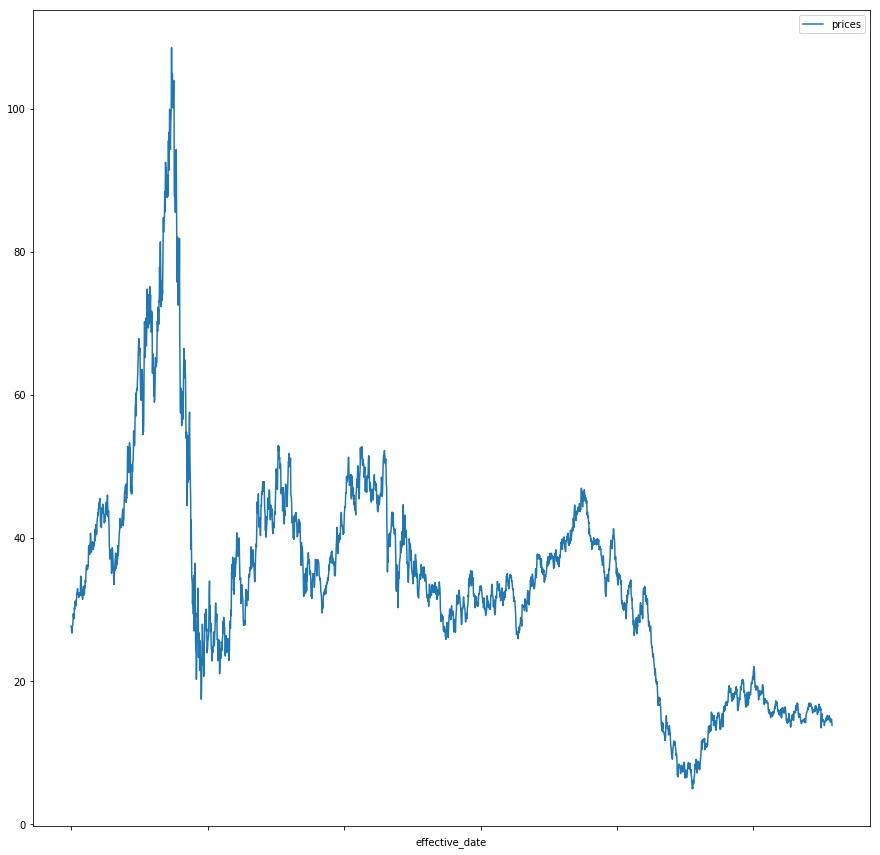

In [6]:
plt.rcParams["figure.figsize"] = [15, 15]

df = pd.read_csv('securities_history.csv')
X = df[['effective_date', 'security_id', 'adjusted_price']]
table = X.pivot(index='security_id', columns='effective_date', values='adjusted_price')

def getDataFrameOfStock(security_id):
    prices = table.loc[security_id]
    prices_df = pd.DataFrame(data={'prices': prices}, index=prices.index)
    return prices_df
    
stockDF = getDataFrameOfStock('US12653C1080')
# backfilling the first price (we have already studied the distribution of NaN in task 1)
stockDF = stockDF.bfill() 
stockDF.plot()

Predicting 1, 5, 10 steps ahead becomes unsurprisingly less and less accurate. moving window size = 5. Note: what we see below is only the test set, not the entire stock lifetime.

r2 score is: 0.9623801801892021for future index 1
r2 score is: 0.8919460545625282for future index 5
r2 score is: 0.7935916067979498for future index 10


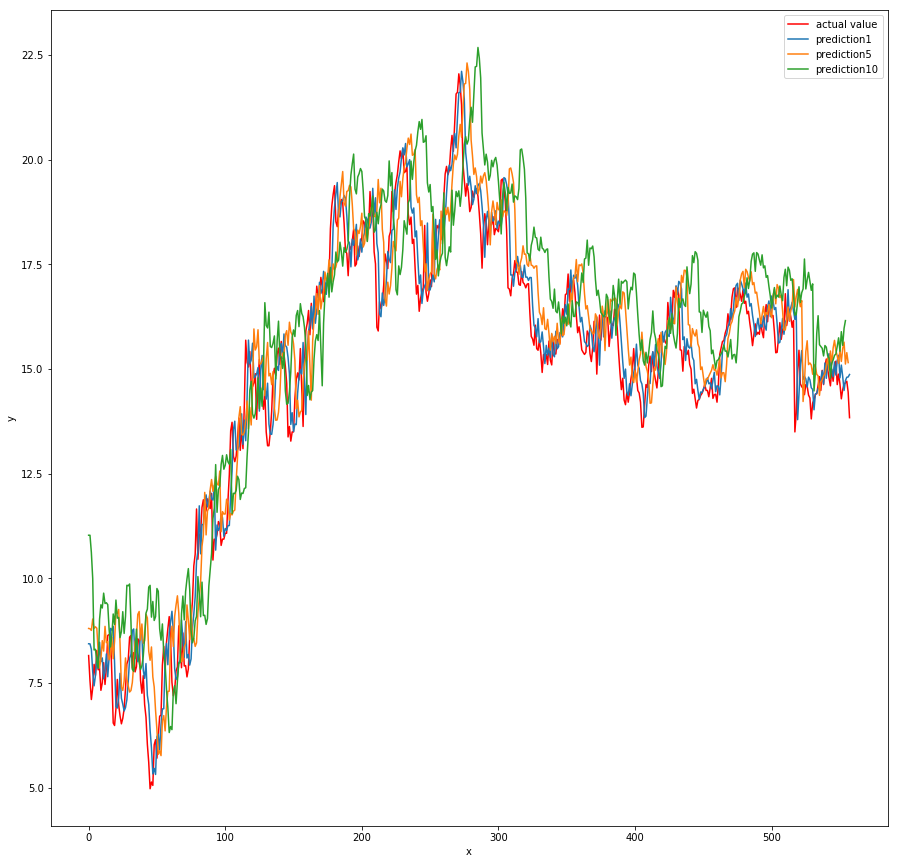

In [7]:
PredictionVsActualValuesPlot(stockDF.values.ravel(), [1, 5, 10], movingWindowSize=5)


The assumption in Linear Regression is no or little multi collinearity.
This is definitely does not have to be borne out here, because in a time series we assume that a price at a given time is influenced only by a finite window of prices in the past, i.e. a finite length markov process (and this is why for the train_test split to work properly, shuffle of samples must be False (i.e, consecutive times). Taking samples randomly in inconsecutive times immediately breaks the prediction).

Nonetheless, in spite of the fact that the prices in the moving window are not necessarily linearly independent, the linear regression seems to work fairly well.


Thank you


Sefi.
